# KARPHY'S CNN 
The notebook is used to experiment with video classification using karphy's CNN as discussed in https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42455.pdf

In [3]:
import tensorflow as tf
# import keras
tf.enable_eager_execution()
import tensorflow_datasets as tfds
import os
import zipfile
# from tensorflow.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pydot

W0807 09:34:01.391318 4579505600 module_wrapper.py:136] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



## Reading in data
The "ucf101" dataset from tensorflow will be used. More information on this dataset can be found here URL: https://www.crcv.ucf.edu/data/UCF101.php

In [6]:
ucf101_dataset, ucf101_info = tfds.load(name="ucf101", with_info=True)
ucf101_train , ucf101_test = ucf101_dataset["train"], ucf101_dataset["test"]
print(type(ucf101_info))
assert isinstance(ucf101_train, tf.data.Dataset)
assert isinstance(ucf101_test, tf.data.Dataset)

print('number of training examples:', ucf101_info.splits["train"].num_examples)
print('number of test examples:', ucf101_info.splits["test"].num_examples)
print('number of labels:', ucf101_info.features["label"].num_classes)

<class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>
number of training examples: 9537
number of test examples: 3783
number of labels: 101


### Looking into the dataset
The dataset has a pixel size of 256 x 256 x 3 for each video. 

In [12]:
print(ucf101_train.take(1))

<DatasetV1Adapter shapes: {video: (?, 256, 256, 3), label: ()}, types: {video: tf.uint8, label: tf.int64}>


### Formating data
* normalizing pixels? why again
* The pixels are rescaled to a size of 170 x 170 x 3 as suggested by the paper 
* The models suggested in the paper can take one frame of 10 frames depending if the model is early fusion of late fusion

In [8]:
IMG_SIZE = 170

def format_videos(dataset):
    dataset["video"] = tf.cast(dataset["video"], tf.float32)
    dataset["video"] = (dataset["video"]/255)
    dataset["video"] = tf.image.resize(dataset["video"], (IMG_SIZE,IMG_SIZE))
    return dataset
    

In [9]:
def select_first_frame(dataset):
    dataset["video"] = dataset["video"][0]
    return dataset 
    

In [10]:
def select_frame_from_i_to_T(dataset,i, T):
    dataset["video"] = dataset["video"][i:T]
    return dataset

In [11]:
def select_frame_at_T(dataset, T):
    dataset["video"] = dataset["video"][T]
    return dataset 

In [12]:
def convert_to_tuple(dataset):
    x = dataset["video"]
    y = dataset["label"]
    return x,y 

changing resizing image and 

In [24]:
train = ucf101_train.map(format_videos)
train = train.map(select_first_frame)
train = train.map(convert_to_tuple)

test = ucf101_test.map(format_videos)
test = test.map(select_first_frame)
test = test.map(convert_to_tuple)


for d in ucf101_train.take(1):
    print(d["label"])
    print(d["video"].shape)  
for x, y in train.take(1):
    print(x.shape)   

tf.Tensor(96, shape=(), dtype=int64)
(74, 256, 256, 3)
(170, 170, 3)


Displaying images in video last image

loading test dataset

In [25]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2 #1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([Dimension(32), Dimension(170), Dimension(170), Dimension(3)])

##

## Single Frame model

Creating single frame model from paper

Creating custom layer for local response normalization

In [16]:
class MyLRNLayer(tf.keras.layers.Layer):
    def __init__(self, depth_radius=5,bias=1,alpha=1,beta=0.5, **kwargs):
#         self.output_dim = output_dim
        self.depth_radius = depth_radius
        self.bias = bias
        self.alpha = alpha
        self.beta = beta
        super(MyLRNLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(None),
                                      initializer='uniform',
                                      trainable=False)
        super(MyLRNLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.nn.local_response_normalization(x,self.depth_radius,self.bias,self.alpha,self.beta)

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.output_dim)


In [26]:
layer = MyLRNLayer()
print(layer(tf.zeros([1, 54, 54, 96])).shape)
print(len(layer.trainable_variables))

(1, 54, 54, 96)
0


In [27]:
modellrn = tf.keras.models.Sequential([MyLRNLayer(input_shape=(170, 170, 3),batch_size=1)])
modellrn.build()
modellrn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_lrn_layer_5 (MyLRNLayer)  (1, 170, 170, 3)          1         
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________


In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3)),
    
  MyLRNLayer(),  
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  MyLRNLayer(), 
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
    
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
my_lrn_layer_2 (MyLRNLayer)  (None, 54, 54, 96)        1         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
my_lrn_layer_3 (MyLRNLayer)  (None, 23, 23, 256)       1         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 384)       885120    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 384)      

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(train_batches, 
      epochs=1,
      verbose=1)

W0806 23:06:28.013512 4597519808 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0806 23:06:28.196951 4597519808 deprecation.py:323] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


299/299 [==============================] - 1829s 6s/step - loss: 4.6158 - acc: 0.0095


# Improving the single frame model by using batch normalization 

In [20]:
batch_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3), batch_size=32),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

In [21]:
batch_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (32, 54, 54, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (32, 54, 54, 96)          384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 27, 27, 96)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 23, 23, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (32, 23, 23, 256)         1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 21, 21, 384)         885120    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (32, 10, 10, 384)        

In [22]:
batch_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
batch_model.fit(train_batches, 
      epochs=1,
      verbose=1)

    298/Unknown - 1735s 6s/step - loss: 4.6098 - acc: 0.0116

InvalidArgumentError:  Matrix size-incompatible: In[0]: [32,72], In[1]: [2304,4096]
	 [[node dense_3/Relu (defined at /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1657) ]] [Op:__inference_keras_scratch_graph_6292]

Function call stack:
keras_scratch_graph


In [22]:
data, info = tfds.load("ucf101", with_info=True)
train_data, test_data = data['train'], data['test']
assert isinstance(train_data, tf.data.Dataset)
print(info.features['label'].num_classes)
print(info.splits['train'].num_examples)

101
9537


In [ ]:
history = model.fit_generator(train_generator,
#       steps_per_epoch=8,  
      epochs=1,
      verbose=1,
      callbacks=[callbacks])

# Early Fusion



## Early Fusion with Local response normalization

In [26]:
train_multi_frame_T = ucf101_train.map(format_videos)
train_multi_frame_T = train_multi_frame_T.map(lambda x: select_frame_from_i_to_T(x,10,20))
train_multi_frame_T = train_multi_frame_T.map(convert_to_tuple)

test_multi_frame_T = ucf101_test.map(format_videos)
test_multi_frame_T = test_multi_frame_T.map(lambda x:select_frame_from_i_to_T(x,10,20))
test_multi_frame_T = test_multi_frame_T.map(convert_to_tuple)

train_multi_frame_T_batches = train_multi_frame_T.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_multi_frame_T_batches = test_multi_frame_T.batch(BATCH_SIZE)

for image_batch, label_batch in train_multi_frame_T_batches.take(1):
    pass

image_batch.shape


TensorShape([Dimension(32), Dimension(10), Dimension(170), Dimension(170), Dimension(3)])

In [70]:
model_early_fusion_lrn = tf.keras.models.Sequential([
  tf.keras.layers.Conv3D(96, (11,11,3), strides=3 , activation='relu', input_shape=(10,170, 170, 3)),
    
  MyLRNLayer(),  
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    
  MyLRNLayer(), 
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
    
  tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
    
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Flatten(),
    
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(101, activation='softmax')
])

ValueError: Negative dimension size caused by subtracting 11 from 10 for 'conv3d_1/Conv3D' (op: 'Conv3D') with input shapes: [?,10,170,170,3], [11,11,3,3,96].

In [ ]:
model_early_fusion_lrn.summary()

In [ ]:
model_early_fusion_lrn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
model_early_fusion_lrn.fit(train_multi_frame_T_batches, 
      epochs=3,
      verbose=1)

W0807 09:34:44.041754 4579505600 module_wrapper.py:136] From /anaconda2/envs/py37/lib/python3.7/site-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



NameError: name 'model_early_fusion_lrn' is not defined

## Early Fusion with Batch normalization

# Late Fusion

In [ ]:
x = model.layers[index].output

## Late Fusion with Local response normalization

In [46]:
train_start = ucf101_train.map(format_videos)
train_start = train_start.map(lambda x: select_frame_at_T(x,0))
train_start = train_start.map(convert_to_tuple)

test_start = ucf101_test.map(format_videos)
test_start = test_start.map(lambda x: select_frame_at_T(x,0))
test_start = test_start.map(convert_to_tuple)


train_end = ucf101_train.map(format_videos)
train_end = train_end.map(lambda x: select_frame_at_T(x,10))
train_end = train_end.map(convert_to_tuple)

test_end = ucf101_test.map(format_videos)
test_end = test_end.map(lambda x: select_frame_at_T(x,10))
test_end = test_end.map(convert_to_tuple)

for x, y in test_start.take(1):
    print(x.shape)
    print(y.shape, y)
    
for x, y in train_end.take(1):
    print(x.shape)
    print(y.shape, y)    

(170, 170, 3)
() tf.Tensor(76, shape=(), dtype=int64)
(170, 170, 3)
() tf.Tensor(96, shape=(), dtype=int64)


In [53]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 0 #1000
# not so the values are aligned
train_start_batches = train_start.batch(BATCH_SIZE)
test_start_batches = test_start.batch(BATCH_SIZE)
train_end_batches = train_end.batch(BATCH_SIZE)
test_end_batches = test_end.batch(BATCH_SIZE)

for x, y in train_start_batches.take(1):
    print(x.shape)
    print(y.shape) 
# print(train_start_batches.take(1))

(32, 170, 170, 3)
(32,)


In [17]:
train_clip_start = tf.keras.Input(shape=(170, 170, 3), name='start')  # Variable-length sequence of ints
train_clip_end = tf.keras.Input(shape=(170, 170, 3), name='end')  # Variable-length sequence of ints

# Embed each word in the title into a 64-dimensional vector
start_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_start)
start_features = MyLRNLayer()(start_features)  
start_features = tf.keras.layers.MaxPooling2D(2, 2)(start_features) 
start_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(start_features) 
start_features = MyLRNLayer()(start_features) 
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)  


# Embed each word in the title into a 64-dimensional vector
end_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_end)
end_features = MyLRNLayer()(end_features)  
end_features = tf.keras.layers.MaxPooling2D(2, 2)(end_features) 
end_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(end_features) 
end_features = MyLRNLayer()(end_features) 
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)  

# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate([start_features, end_features])
x =  tf.keras.layers.Flatten()(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
x =  tf.keras.layers.Dense(101, activation='softmax')(x)

# Instantiate an end-to-end model predicting both priority and department
late_fusion_model_LRN = tf.keras.Model(inputs=[train_clip_start, train_clip_end],
                    outputs=[x])

In [18]:
late_fusion_model_LRN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
start (InputLayer)              [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
end (InputLayer)                [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 96)   34944       start[0][0]                      
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 54, 54, 96)   34944       end[0][0]                        
______________________________________________________________________________________________

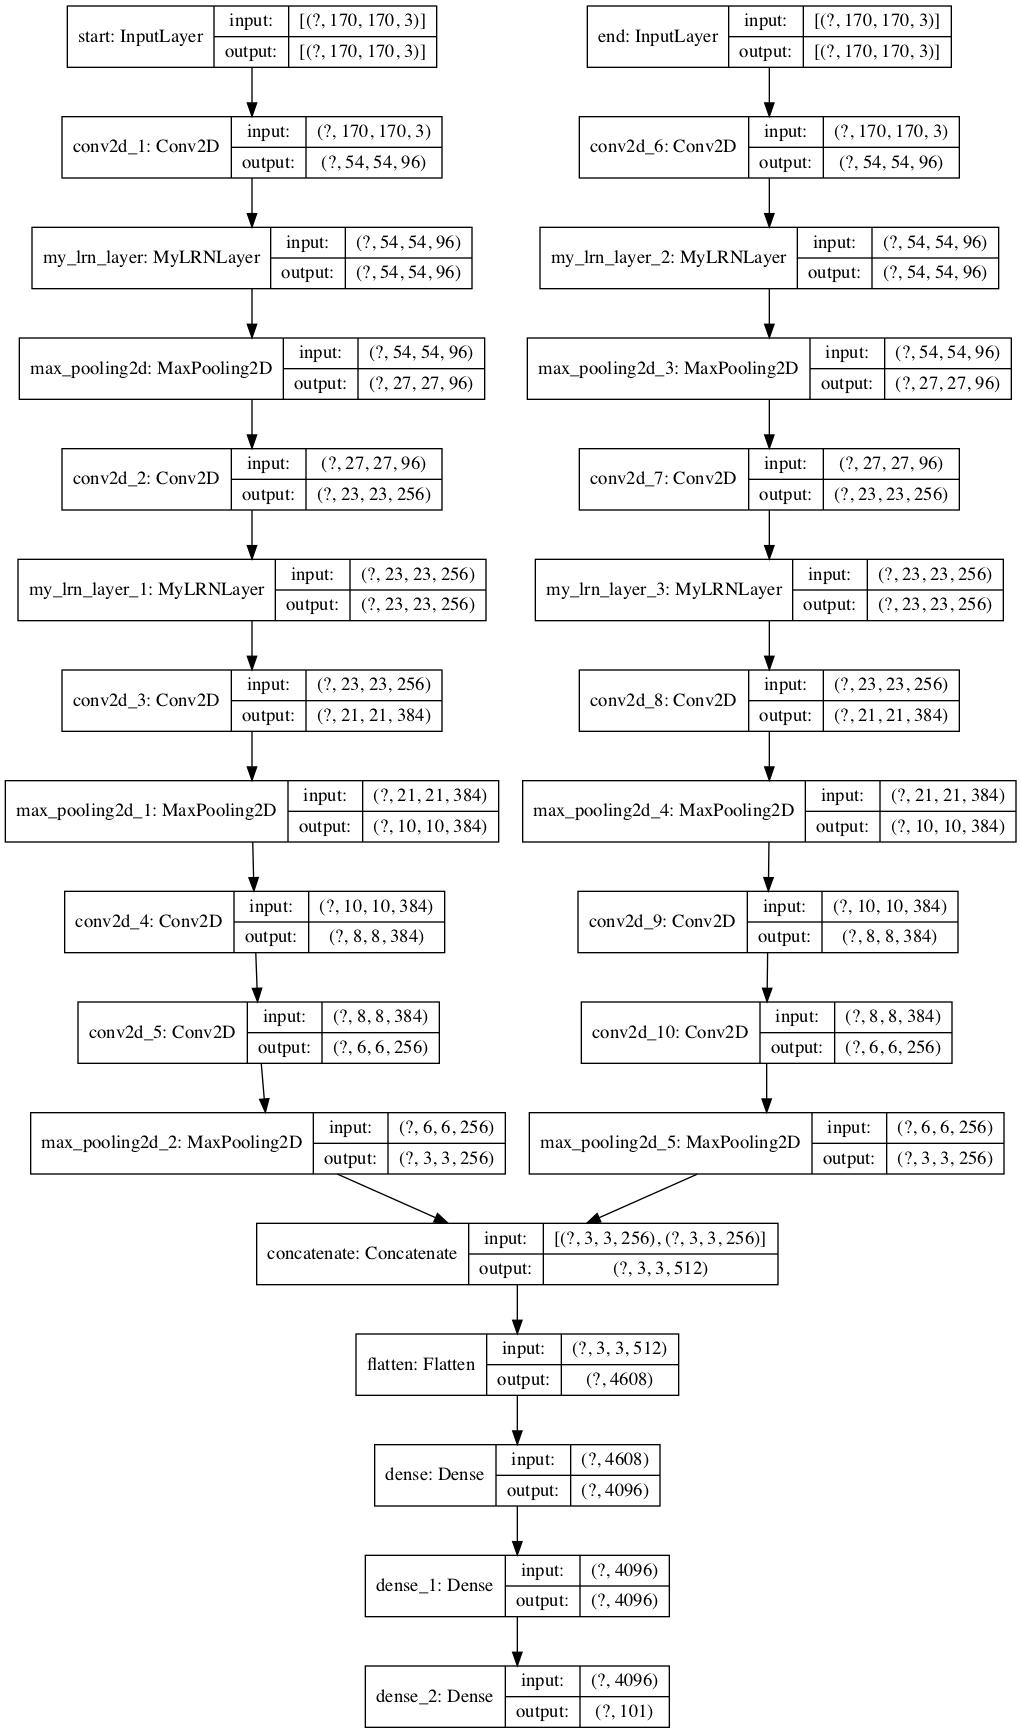

In [19]:
tf.keras.utils.plot_model(late_fusion_model_LRN, 'late_fusion_model_LRN.png', show_shapes=True)

In [33]:
late_fusion_model_LRN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# late_fusion_model_LRN.compile(optimizer='adam',
#               loss=['parse_categorical_crossentropy', 'parse_categorical_crossentropy'])

In [47]:
late_fusion_model_LRN.fit({'start': train_start_batches, 'end':test_end_batches }, 
      epochs=1,
      batch_size=32)

AttributeError: 'DatasetV1Adapter' object has no attribute 'shape'

## Late Fusion with Batch normalization

In [37]:
train_clip_start = tf.keras.Input(shape=(170, 170, 3), name='start')  # Variable-length sequence of ints
train_clip_end = tf.keras.Input(shape=(170, 170, 3), name='end')  # Variable-length sequence of ints

# Embed each word in the title into a 64-dimensional vector
start_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_start)
start_features = tf.keras.layers.BatchNormalization()(start_features)  
start_features = tf.keras.layers.MaxPooling2D(2, 2)(start_features) 
start_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(start_features) 
start_features = tf.keras.layers.BatchNormalization()(start_features) 
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)
start_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(start_features)
start_features = tf.keras.layers.MaxPooling2D(2,2)(start_features)  


# Embed each word in the title into a 64-dimensional vector
end_features = tf.keras.layers.Conv2D(96, (11,11), strides=3 , activation='relu', input_shape=(170, 170, 3))(train_clip_end)
end_features = tf.keras.layers.BatchNormalization()(end_features)  
end_features = tf.keras.layers.MaxPooling2D(2, 2)(end_features) 
end_features = tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu')(end_features) 
end_features = tf.keras.layers.BatchNormalization()(end_features) 
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)
end_features = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu')(end_features)
end_features = tf.keras.layers.MaxPooling2D(2,2)(end_features)  

# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate([start_features, end_features])
x =  tf.keras.layers.Flatten()(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
x =  tf.keras.layers.Dense(4096, activation='relu')(x)
x =  tf.keras.layers.Dense(101, activation='softmax')(x)

# Instantiate an end-to-end model predicting both priority and department
late_fusion_model_bn = tf.keras.Model(inputs=[train_clip_start, train_clip_end],
                    outputs=[x])

In [73]:
late_fusion_model_bn.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
start (InputLayer)              [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
end (InputLayer)                [(None, 170, 170, 3) 0                                            
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 54, 54, 96)   34944       start[0][0]                      
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 54, 54, 96)   34944       end[0][0]                        
____________________________________________________________________________________________

# Slow Fusion

In [ ]:
Slow Fusion

In [ ]:
inputs_1 = tf.keras.Input(shape=(32,))  # Returns a placeholder tensor
inputs_T = tf.keras.Input(shape=(32,))  # Returns a placeholder tensor

# A layer instance is callable on a tensor, and returns a tensor.
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=predictions)

# The compile step specifies the training configuration.
model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trains for 5 epochs
model.fit(data, labels, batch_size=32, epochs=5)

In [79]:
tf.keras.layers?

TypeError: 'MapDataset' object is not subscriptable

In [73]:
ucf101_train.map?

In [102]:
tf.keras.layers.Conv3D?